In [1]:
import numpy as np
import pandas as pd
from os import listdir
import csv

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# in case this error appear
# Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead

# may need to update or change the version of this libs in case the lineplot not work, 

print('sns: ',sns.__version__, 'used: 0.13.0')
print('plt: ',matplotlib.__version__, 'used: 3.8.2')

# pip install seaborn==0.13.0
# or
# pip install seaborn --upgrade

sns:  0.13.2 used: 0.13.0
plt:  3.8.4 used: 3.8.2


In [3]:
# get the number of valid individuos from each iteration
def get_n_valids(file_path, file_name, use_P_B_as_valid=False):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    else:
        # penalty and valid were not saved in this test, so need to be created
        df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
        df['valid'] = (df['penalty'] == 0)
    
    #
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_valids_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
    #     print('i', i, ' np_size', size, 'locs', locs)
        n_valids = df.iloc[locs]['valid']
        n_valids = sum(n_valids)
        n_valids_list.append(n_valids)
    return n_valids_list

In [4]:
# biggest percentage of difference on each individual parameter
def diff(x, y, ignore_last=False):
    max_diff = 0
    end = 1 if ignore_last else 0 # remove 1 from len if ignore_last
    for i in range(len(x) - end):
        cur_diff = abs(x[i] - y[i]) / max(x[i], y[i])
        max_diff = max(max_diff, cur_diff)
    return max_diff

# list of tuples, (differents, number of individuals) for each generation
def get_n_differents(file_path, file_name, only_valids=True, use_P_B_as_valid=False, threshold=0.004):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    
    # Get iteration counter lines
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_diffs_list = []
    n_totals_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
        
        # Extract relevant columns
        df_temp = df.iloc[locs][['D', 'AEdAO', 'PdD', 'Z']]
        df_temp = df_temp.astype({'D':float, 'AEdAO':float, 'PdD':float, 'Z':int})
        valids_np = df.iloc[locs]['valid'].to_numpy()
        
        # Calculate differences
        df_temp_np = df_temp.to_numpy()
        diffs_np = np.ones(len(df_temp_np)) # got to be 1 so the last one is bigger than the threshold, since it's not being compared with the others
        for i in range(len(df_temp_np)-1):
            elem_i = df_temp_np[i]
            min_diff = float('inf')
            # compare with the next elements in the list
            for j in range(i+1, len(df_temp_np)):
                elem_j = df_temp_np[j]
                curr_diff = diff(elem_i, elem_j, ignore_last=True)
                curr_diff += abs(df_temp_np[i][-1] - df_temp_np[j][-1])
                min_diff = min(min_diff, curr_diff)
            diffs_np[i] = min_diff
        equals_np = [min_diff < threshold for min_diff in diffs_np]
        differents_np = np.logical_not(equals_np)
        
        # Filter for only valids if required
        if only_valids:
            differents_np = np.logical_and(differents_np, valids_np)
            
        # Calculate counts
        n_diffs = 0
        
        # TODO: find why in the case of DE_mod the values of differents_np are '1.0' and '0.0'. 
        # If corrected, the below conditional will be no more needed and we use directly what is on the else condition
        differents_np_str = np.array(differents_np, dtype=str)
        unique_values = np.unique(differents_np_str)
        if '1.0' in unique_values or '0.0' in unique_values:
            differents_np_str = np.where(differents_np_str == '0.0', 0.0, differents_np_str)
            differents_np_str = np.where(differents_np_str == '1.0', 1.0, differents_np_str)
            differents_np_str = np.where(differents_np_str == 'True', 1.0, differents_np_str)
            differents_np_str = np.where(differents_np_str == 'False', 0.0, differents_np_str)
            
            differents_np = differents_np_str.astype(float)
            
            n_diffs = np.count_nonzero(differents_np)
        else:
            n_diffs  = sum(differents_np)
        
        n_totals = len(differents_np)
        n_diffs_list.append(n_diffs)
        n_totals_list.append(n_totals)
    return [n_diffs_list, n_totals_list]


## Calculate the difs

In [5]:
# path for the directory containing each folder with the solvers executions
dir_run =  '../results'

In [6]:
valids_by_vs = {}

# temporary
counter = {}

# enter in the folders until reach the files with the executions
for solver_run in listdir(dir_run):
    solver_run = dir_run+'/'+solver_run
    # dir's created by the multiple_run_solver
    for solver_vs in listdir(solver_run):
        solver_vs = solver_run+'/'+solver_vs
        for dir_seed in listdir(solver_vs):
            
            if (dir_seed == 'best_configuration.csv'):
                continue
            
            dir_seed = solver_vs+'/'+dir_seed
            print('reading', dir_seed)
            # get the config file for that seed execution
            config_file = [filename for filename in listdir(dir_seed) if 'config' in filename]
            if len(config_file) > 0:
                config_file = config_file[0]
                config_file = dir_seed+'/'+config_file
                with open(config_file, 'r', newline='\n') as file:
                    lines = file.readlines()[:6]
                    vs    = lines[0].strip().split(',')[1]
                    nPop  = lines[1].strip().split(',')[1]
                    maxIt = lines[2].strip().split(',')[1]
                    seed  = lines[3].strip().split(',')[1]
                    solver= lines[4].strip().split(',')[1]
                    newFit= lines[5].strip().split(',')[1]
                vs = float(vs)
                nPop = int(nPop)
                maxIt = int(maxIt)
                # use P_B as valid, for the DE replicated, where the P_B = 0 if the propeller is invalid
                use_P_B_as_valid = True if 'False' in newFit else False
            # get csv files containing all the run (Z.csv   ex: 2.csv - 7.csv)
            #    remove '.csv' and test if the rest of the string is only numbers
            files = [filename for filename in listdir(dir_seed) if filename[:-4].isdigit()]
            for file_name in files:
                # calculate the number of valids
                n_valids, _ = get_n_differents(dir_seed, file_name, use_P_B_as_valid=use_P_B_as_valid, only_valids=True)

                # difEvo has generation 0 together with 1 for some reason (0 is an extra generation I guess)
                if 'DE' in solver:
                    # do the ceil of mean of this 2 first generations
                    n_valids[0] = int((n_valids[0] / 2) + 0.6)
                    
                # initialize dirs if they arent initialized
                if vs not in counter:
                    counter[vs] = {}
                if vs not in valids_by_vs:
                    valids_by_vs[vs] = {}
                if solver not in counter[vs]:
                    counter[vs][solver] = 0
                
                # if its the first valid in the vs, solver, put it as the first, other whise add
                if solver not in valids_by_vs[vs]:
                    valids_by_vs[vs][solver] =  n_valids
                else:
                    # add the valids to the count
                    valids_by_vs[vs][solver] = np.add(valids_by_vs[vs][solver], n_valids)
                    
            # count only per seed, not per csv
            counter[vs][solver] += 1
            
            
 # after passed the for each run dir
for vs in valids_by_vs:
    for solver in valids_by_vs[vs]:
        # get the mean
        valids_by_vs[vs][solver] = np.divide(valids_by_vs[vs][solver], counter[vs][solver])
        

reading ../results/cmaes_2024_04_22_16h15/7_0/0
reading ../results/cmaes_2024_04_22_16h15/7_0/1
reading ../results/cmaes_2024_04_22_16h15/7_0/2
reading ../results/cmaes_2024_04_22_16h15/7_0/3
reading ../results/cmaes_2024_04_22_16h15/7_0/4
reading ../results/cmaes_2024_04_22_16h15/7_0/5
reading ../results/cmaes_2024_04_22_16h15/7_0/6
reading ../results/cmaes_2024_04_22_16h15/7_0/7
reading ../results/cmaes_2024_04_22_16h15/7_0/8
reading ../results/cmaes_2024_04_22_16h15/7_0/9
reading ../results/cmaes_2024_04_22_16h15/7_5/0
reading ../results/cmaes_2024_04_22_16h15/7_5/1
reading ../results/cmaes_2024_04_22_16h15/7_5/2
reading ../results/cmaes_2024_04_22_16h15/7_5/3
reading ../results/cmaes_2024_04_22_16h15/7_5/4
reading ../results/cmaes_2024_04_22_16h15/7_5/5
reading ../results/cmaes_2024_04_22_16h15/7_5/6
reading ../results/cmaes_2024_04_22_16h15/7_5/7
reading ../results/cmaes_2024_04_22_16h15/7_5/8
reading ../results/cmaes_2024_04_22_16h15/7_5/9
reading ../results/cmaes_2024_04_22_16h1

In [ ]:
#
valids_by_vs[7.0]

## Show Graph

In [7]:
solver_names = {'cmaes':   'CMA-ES', 
                'openaies': 'OpenAI-ES',
                'DE': 'DE Replicated',
                'DE_mod': 'DE Proposed'
               }

line_styles = {'cmaes': 'solid',
               'openaies': 'dashdot',
               'DE': 'dotted',
               'DE_mod':'dashed'
              }

In [8]:
def create_graph(vs):
    plt.rcParams.update({'font.size': 16})
    
    plt.figure(figsize=(7,4), dpi=100)


    x = [valids_by_vs[vs][solver] for solver in valids_by_vs[vs]]
    lines = []
    for solver in valids_by_vs[vs]:
        line, = plt.plot(valids_by_vs[vs][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)

    plt.xlabel('generation')
    plt.ylabel('number of valid different configurations')
#     plt.legend(handles=lines, loc='lower right')
    plt.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1))

    plt.title('VS = '+str(vs))
    
    plt.ylim(0, 30)
    
    plt.show()

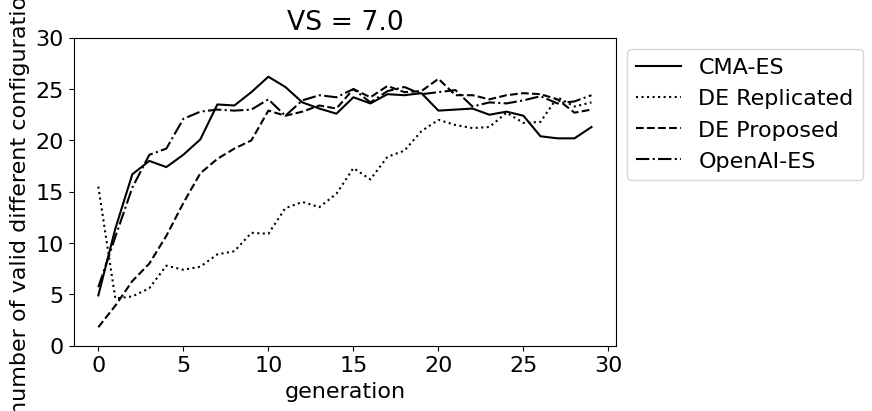

In [9]:
create_graph(7.0)

In [ ]:
create_graph(7.5)

In [ ]:
create_graph(8.0)

In [ ]:
create_graph(8.5)

# Graphs for the article

In [9]:
y_axis_label = 'Number of different\nvalid configurations'   # en
# y_axis_label = 'Número de diferentes\nconfigurações válidas' # pt

x_axis_label = 'Generation' # en
# x_axis_label = 'Geração'    # pt

font_size = 20

In [10]:
def create_double_graph(vs1, vs2, save=False):
    # Create a larger figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed
#     plt.rcParams.update({'font.size': 15})

    # Create the first plot
    x = [valids_by_vs[vs1][solver] for solver in valids_by_vs[vs1]]
    lines = []
    for solver in valids_by_vs[vs1]:
        line, = ax1.plot(valids_by_vs[vs1][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)
    ax1.set_xlabel(x_axis_label, fontsize=font_size)
    ax1.set_ylabel(y_axis_label, fontsize=font_size) 
    ax1.legend([],[], frameon=False)
    ax1.set_title('VS = '+str(vs1), fontsize=font_size)
    ax1.set_ylim(0, 30)

    # Create the second plot
    x = [valids_by_vs[vs2][solver] for solver in valids_by_vs[vs2]]
    lines = []
    for solver in valids_by_vs[vs2]:
        line, = ax2.plot(valids_by_vs[vs2][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)
    ax2.set_xlabel(x_axis_label, fontsize=font_size)
    ax2.set_ylabel(y_axis_label, fontsize=font_size)
    ax2.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_title('VS = '+str(vs2), fontsize=font_size)
    ax2.set_ylim(0, 30)
    
    # ajusts
    plt.tight_layout()
    
    # save
    if save:
        name_f = 'diffs_'+ str(vs1).replace('.','_') + 'and' + str(vs2).replace('.','_') + '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved as:', name_f)
        
    
    # Display the plots
    plt.show()


saved as: diffs_7_0and7_5.pdf


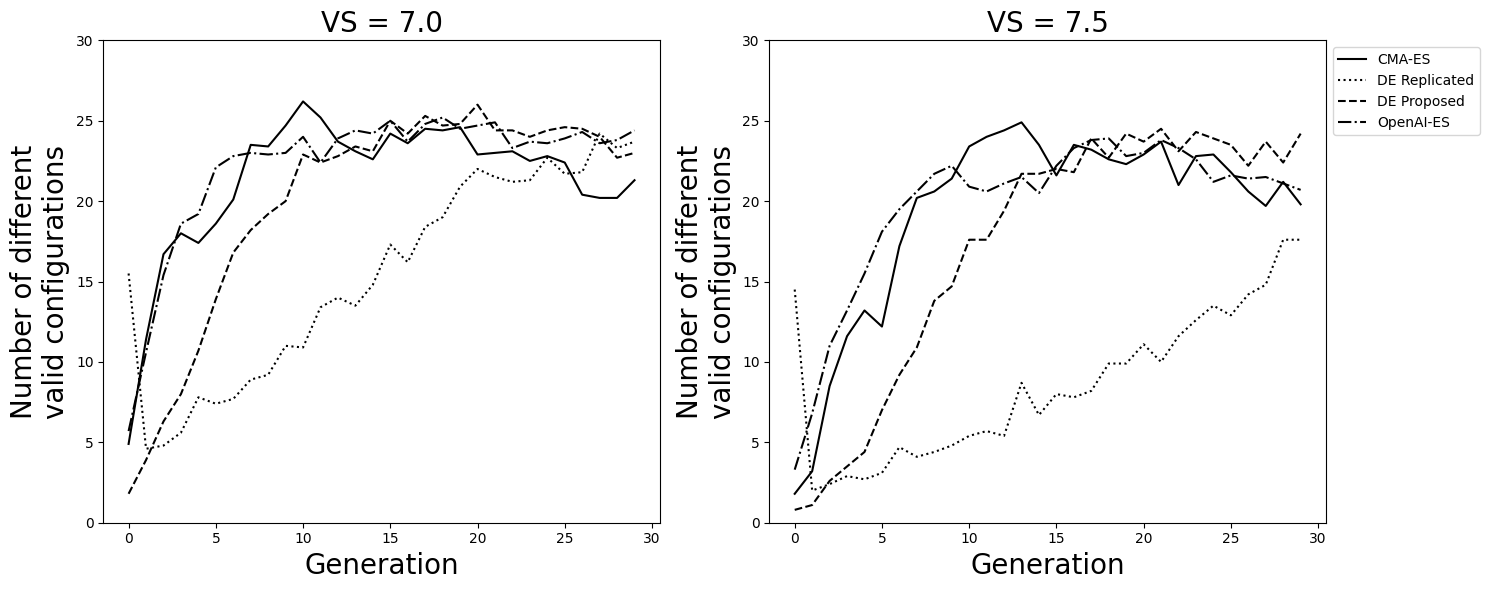

In [11]:
create_double_graph(7.0, 7.5, save=True)

saved as: diffs_8_0and8_5.pdf


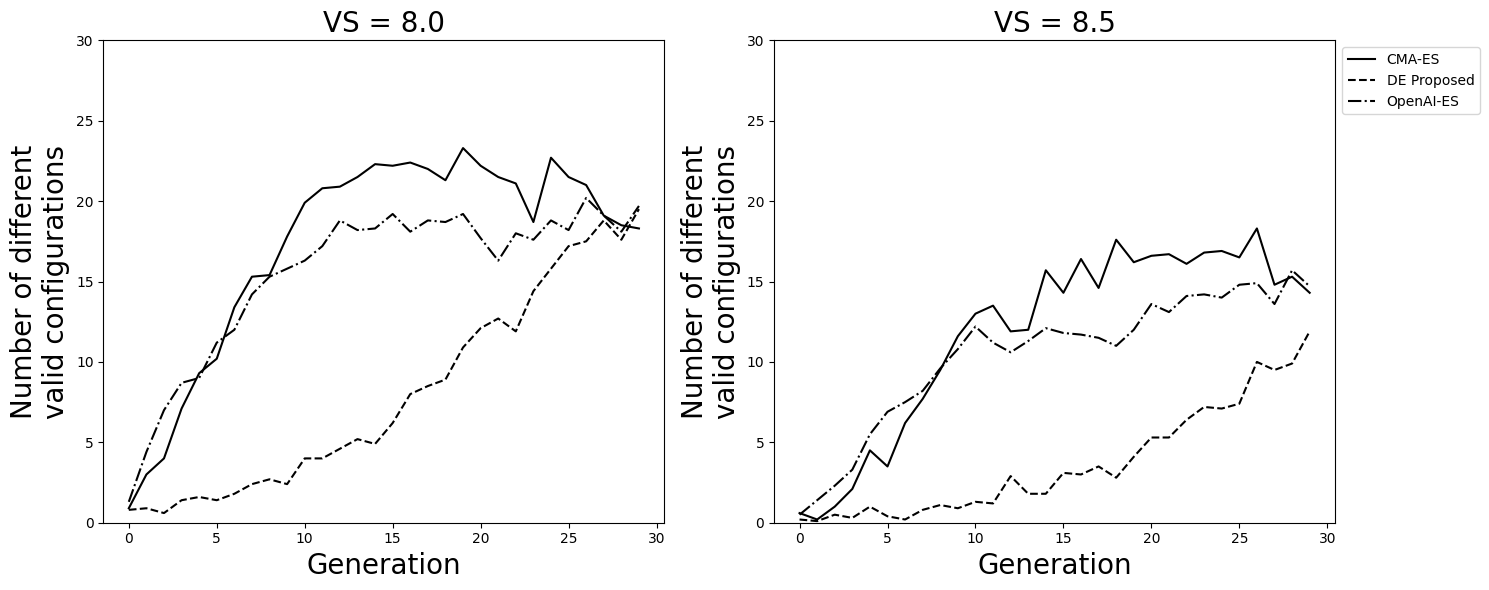

In [12]:
create_double_graph(8.0, 8.5, save=True)